# Домашнее задание 6

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_6

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию координатного спуска (смотри семинар). 

Для такого метода подберите шаг $\gamma$ для наилучшей сходимости постройте график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число арифмитических операций при подсчете "градиента"). Постройте на этом же графике сходимость честного градиентного спуска c наилучшим шагом сходимости. Сделайте вывод о характере сходимости нового метода.

In [1]:
import numpy as np
from numpy import linalg
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import pandas as pd
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time

In [2]:
d = 100
mu = 1
L = 1000

def positive_determined_matrix(d, mu, L): #генерация положительно-определенной матрицы, так чтобы A-mu*I >= 0
    i = 0
    while i == 0:
        diagonal_entries = np.random.uniform(mu, L,d)
        diagonal_entries[0] = mu
        diagonal_entries[1] = L
        D = np.diag(diagonal_entries)
        m = ortho_group.rvs(d)
        A = m.dot(D).dot(np.linalg.inv(m))
        if (np.all(np.linalg.eigvals(A-mu*np.eye(d)) >= 0)):
            i += 1
        print(np.all(np.linalg.eigvals(A-mu*np.eye(d)) >= 0))
    return A

A = positive_determined_matrix(d, mu, L)
print("Проверка на положительную определенность A:", np.all(np.linalg.eigvals(A) >= 0))
print("Проверка на положительную определенность A - mu*E:", np.all(np.linalg.eigvals(A - mu*np.eye(d)) >= 0))

False
False
False
True
Проверка на положительную определенность A: True
Проверка на положительную определенность A - mu*E: True


In [3]:
b = np.random.uniform(0, 2, d)
def gradient(x, A, b):
    return A.dot(x) - b

In [4]:
def Coord_SGD(A, b, start, learning_rate, amount_of_iterations):
    x = start
    x = x.reshape(1, d)
    timeprog = []
    call = []
    count = 0
    begin_time = time.time()
    for i in range (1, amount_of_iterations):
        rand = np.random.randint(0, d)
        grad = np.zeros(d)
        grad[rand] = A[rand]@x[i-1] - b[rand]
        x = np.vstack([x, x[i-1] - learning_rate*d*grad])
        count += d
        call.append(count)
        timeprog.append(time.time() - begin_time)
    return x, call, timeprog

In [5]:
def gradient_descent(A, b, start, learning_rate, amount_of_iterations):
    x = start
    x = x.reshape(1, d)
    timeprog = []
    call = []
    count = 0
    begin_time = time.time()
    for i in range (1, amount_of_iterations):
        grad = gradient(x[i-1], A, b)
        x = np.vstack([x, x[i-1] - learning_rate*grad])
        count += d*d
        call.append(count)
        timeprog.append(time.time() - begin_time)
    return x, call, timeprog

In [6]:
res1, call1, time1 = Coord_SGD(A, b, np.ones(d), 1/(d*L), 10000)
res0, call0, time0 = gradient_descent(A, b, np.ones(d), 1/(L), 10000)

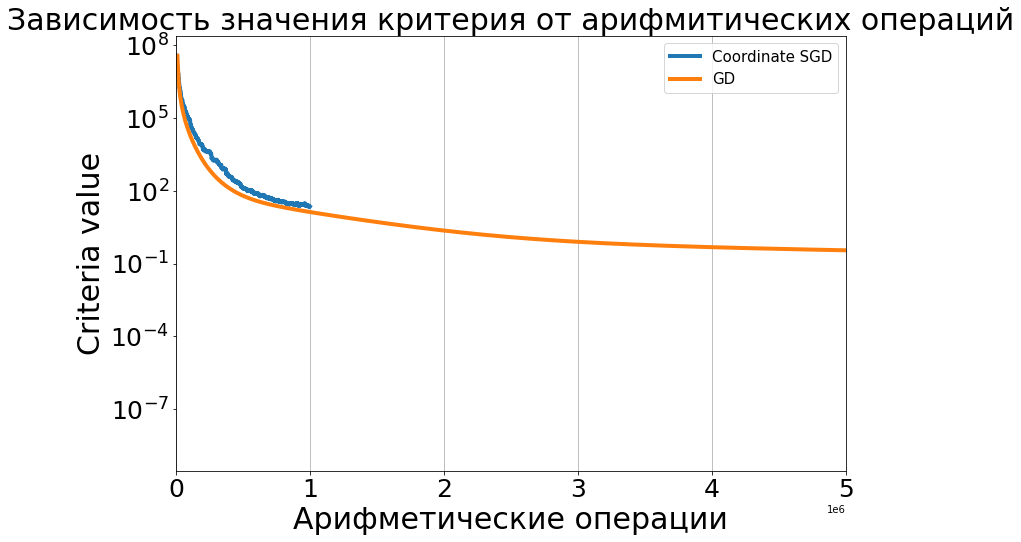

In [7]:
X = np.array([call1[i] for i in range (9998)])
Y = np.array([gradient(res1[i], A, b)@gradient(res1[i], A, b) for i in range (9998)])
X1 = np.array([call0[i] for i in range (9998)])
Y1 = np.array([gradient(res0[i], A, b)@gradient(res0[i], A, b) for i in range (9998)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X, Y, linewidth=4, label = 'Coordinate SGD')
plt.semilogy(X1, Y1, linewidth=4, label = 'GD')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Арифметические операции", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от арифмитических операций", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(0, 5e6)


plt.grid(axis = 'x')

#### сходимость нового метода схожа со сходимостью честного градиентного спуска, но за одинаковое количество итераций градиентный спуск делает в $d$ раз больше итераций и сходиться лучше

__(б)__ В координатном спуске можно брать несколько координат вместо одной. Модифицируйте координнатный спуск, исходя из этого, пробуя разное число координат $b = 1, 5, 10, 20$, а также разные способы сэмплирования: все координатны независимо или зависимо, чтобы не было повторений в батче. Постройте графики аналогичные пункту (а). Сделайте вывод.

In [8]:
def Coord_SGD_batch_indep(A, b, start, learning_rate, amount_of_iterations, batch):
    x = start
    x = x.reshape(1, d)
    timeprog = []
    call = []
    count = 0
    begin_time = time.time()
    for i in range (1, amount_of_iterations):
        rand = np.random.randint(0, d, batch)
        grad = np.zeros(d)
        for k in range (batch):
            grad[rand[k]] = A[rand[k]]@x[i-1] - b[rand[k]]            
        x = np.vstack([x, x[i-1] - learning_rate*d*grad])
        count += d*batch
        call.append(count)
        timeprog.append(time.time() - begin_time)
    return x, call, timeprog

In [9]:
res2, call2, time2 = Coord_SGD_batch_indep(A, b, np.ones(d), 1/(d*L), 10000, 1)
res3, call3, time3 = Coord_SGD_batch_indep(A, b, np.ones(d), 1/(d*L), 10000, 5)
res4, call4, time4 = Coord_SGD_batch_indep(A, b, np.ones(d), 1/(d*L), 10000, 10)
res5, call5, time5 = Coord_SGD_batch_indep(A, b, np.ones(d), 1/(d*L), 10000, 20)

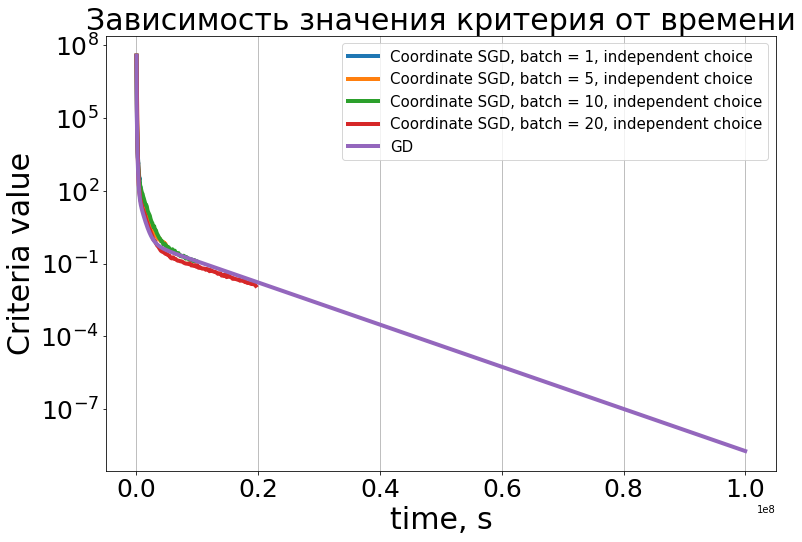

In [10]:
X2 = np.array([call2[100*i] for i in range(0, 99)])
Y2 = np.array([gradient(res2[100*i], A, b)@gradient(res2[100*i], A, b) for i in range (99)])

X3 = np.array([call3[100*i] for i in range(0, 99)])
Y3 = np.array([gradient(res3[100*i], A, b)@gradient(res3[100*i], A, b) for i in range (99)])

X4 = np.array([call4[100*i] for i in range(0, 99)])
Y4 = np.array([gradient(res4[100*i], A, b)@gradient(res4[100*i], A, b) for i in range (99)])

X5 = np.array([call5[100*i] for i in range(0, 99)])
Y5 = np.array([gradient(res5[100*i], A, b)@gradient(res5[100*i], A, b) for i in range (99)])

X1 = np.array([call0[i] for i in range (9998)])
Y1 = np.array([gradient(res0[i], A, b)@gradient(res0[i], A, b) for i in range (9998)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X2, Y2, linewidth=4, label = 'Coordinate SGD, batch = 1, independent choice')
plt.semilogy(X3, Y3, linewidth=4, label = 'Coordinate SGD, batch = 5, independent choice')
plt.semilogy(X4, Y4, linewidth=4, label = 'Coordinate SGD, batch = 10, independent choice')
plt.semilogy(X5, Y5, linewidth=4, label = 'Coordinate SGD, batch = 20, independent choice')
plt.semilogy(X1, Y1, linewidth=4, label = 'GD')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

In [11]:
def Coord_SGD_batch_dep(A, b, start, learning_rate, amount_of_iterations, batch):
    x = start
    x = x.reshape(1, d)
    timeprog = []
    call = []
    count = 0
    begin_time = time.time()
    for i in range (1, amount_of_iterations):
        a = set([-1])
        grad = np.zeros(d)
        for k in range (batch):
            rand = np.random.randint(0, d)
            while a.isdisjoint([rand]) == False:
                rand = np.random.randint(0, d)
            grad[rand] = A[rand]@x[i-1] - b[rand]
            a.add(rand)
        count += d*batch
        call.append(count)
        x = np.vstack([x, x[i-1] - learning_rate*d*grad])
        timeprog.append(time.time() - begin_time)
    return x, call, timeprog

In [12]:
res21, call21, time21 = Coord_SGD_batch_dep(A, b, np.ones(d), 1/(d*L), 10000, 1)
res31, call31, time31 = Coord_SGD_batch_dep(A, b, np.ones(d), 1/(d*L), 10000, 5)
res41, call41, time41 = Coord_SGD_batch_dep(A, b, np.ones(d), 1/(d*L), 10000, 10)
res51, call51, time51 = Coord_SGD_batch_dep(A, b, np.ones(d), 1/(d*L), 10000, 20)

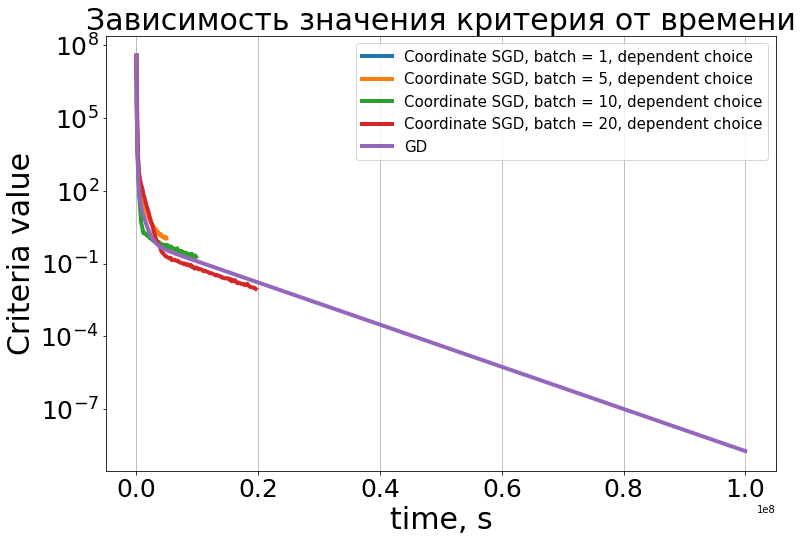

In [13]:
X2 = np.array([call21[100*i] for i in range(0, 99)])
Y2 = np.array([gradient(res21[100*i], A, b)@gradient(res21[100*i], A, b) for i in range (99)])

X3 = np.array([call31[100*i] for i in range(0, 99)])
Y3 = np.array([gradient(res31[100*i], A, b)@gradient(res31[100*i], A, b) for i in range (99)])

X4 = np.array([call41[100*i] for i in range(0, 99)])
Y4 = np.array([gradient(res41[100*i], A, b)@gradient(res41[100*i], A, b) for i in range (99)])

X5 = np.array([call51[100*i] for i in range(0, 99)])
Y5 = np.array([gradient(res51[100*i], A, b)@gradient(res51[100*i], A, b) for i in range (99)])

X1 = np.array([call0[i] for i in range (9998)])
Y1 = np.array([gradient(res0[i], A, b)@gradient(res0[i], A, b) for i in range (9998)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X2, Y2, linewidth=4, label = 'Coordinate SGD, batch = 1, dependent choice')
plt.semilogy(X3, Y3, linewidth=4, label = 'Coordinate SGD, batch = 5, dependent choice')
plt.semilogy(X4, Y4, linewidth=4, label = 'Coordinate SGD, batch = 10, dependent choice')
plt.semilogy(X5, Y5, linewidth=4, label = 'Coordinate SGD, batch = 20, dependent choice')
plt.semilogy(X1, Y1, linewidth=4, label = 'GD')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

#### Если выбирать координаты независимо, то в случае $b = 20$ часто попадаются одинаковые координаты и его сходимость хуже, если выбирать координаты случайно, но заведомо разные, то луший результат, наиболее близкий к обычному градиентному спуску получается при $b = 20$

## Задача 2

Рассмотрим задачу линейной регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. 

In [14]:
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape
print(n, d)
y = 2*y - 3

8124 112


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
n_train, d_train = X_train.shape
n_test, d_test = X_test.shape

#### Оценим константу Липшица аналитически. Для начала рассчитаем $\nabla(||X\omega - y||^2 + \lambda||\omega||^2) = \nabla(f(\omega)).\\$
$d (f(\omega) = d<X\omega - y, X\omega - y> + \lambda d<\omega, \omega> = 2<X\omega - y, Xd\omega> + 2\lambda<\omega, d\omega> = <2X^Т(X\omega - y) + 2\lambda\omega, d\omega>\Rightarrow$

$\nabla(f(\omega)) = 2X^Т(X\omega - y) + \lambda\omega.$

#### Из определения Липшицева градиента с константой L получаем: $||(2X^ТX + \lambda I)(\omega_1 - \omega_0)||\leq||2X^ТX + \lambda I||\cdot||\omega_1 - \omega_0||\Rightarrow L\geq||2X^ТX + \lambda I||$
#### Из теории, $L$ - максимальное собственное значение матрицы $\frac{1}{n}(2X^ТX + \lambda I)$
#### Рассчитаем $\nabla^2(f(\omega))$. Обозначим $d\omega$, как $d\omega_1$, тогда $d^2(f(\omega)) = <(2X^ТX + \lambda I)d\omega_2, d\omega_1>\Rightarrow\nabla^2(f(\omega)) = 2X^ТX + \lambda I$
#### $\mu$ - минимальное собственное значение матрицы $\frac{1}{n} (2X^ТX + \lambda I)$
По скольку $\lambda$ зависит от $L$ и оно мало, то при расчете $L$ не будем его учитывать

In [16]:
L = max(np.linalg.eigvalsh(2/n_train*X_train.T.dot(X_train)))
mu = min(np.linalg.eigvalsh(1/n_train*(2*X_train.T.dot(X_train) + np.eye(d)*L/1000)))
print("L =", L)
print("mu =", mu)
lamb = L/1000

L = 20.67711090297844
mu = 3.1815834589476974e-06


$mu\approx = 0\Rightarrow$ задача выпуклая

__(б)__ Реализуйте координатный SGD, SEGA для задачи линейно регрессии. Каким будете брать $b$? Как будете выбирать шаг и другие параметры методов?

Будем брать $b = 20$, так как во-первых в предыдущем пункте при $b = 20$ CSGD показал лучший результат, а во-вторых дальнейшие эксперименты показали, что при $b = 20$ SEGA сходиться лучше всего. Шаг будем брать $\frac{1}{dL}$, так как при большем шаге методы начинает расходиться, а при меньшем показывает худшие показатели сходимости.

In [17]:
def gradient(X, y, omega):
    return 2/n_train*X.T@(X@omega - y) + 2/n_train*L/1000*omega
    
def gradient_part(X, y, omega, rand):
    return 2/n_train*X.T[rand]@(X@omega - y) + 2/n_train*L/1000*omega[rand]

In [18]:
def Coord_SGD_linear_regression(X, y, start, learning_rate, amount_of_iterations, batch_size):
    omega = start
    omega = omega.reshape(1, d)
    timeprog = []
    call = []
    count = 0
    begin_time = time.time()
    for i in range (1, amount_of_iterations):
        grad = np.zeros(d)
        a = set()
        for k in range (batch_size):
            rand = np.random.randint(0, d)
            while a.isdisjoint([rand]) == False:
                rand = np.random.randint(0, d)
            grad[rand] = gradient_part(X, y, omega[i-1], rand)
            a.add(rand)
        count += batch_size*(n_train*d + n_train)
        call.append(count)
        omega = np.vstack([omega, omega[i-1] - learning_rate*d*grad])
        timeprog.append(time.time() - begin_time)
    return omega, call, timeprog

In [19]:
res1, call1, time1 = Coord_SGD_linear_regression(X_train, y_train, np.ones(d), 1/(d*L), 10000, 20)

In [20]:
def SEGA(X, y, start, lr, amount_of_iterations, batch_size):
    omega = start
    omega = omega.reshape(1, d)
    timeprog = []
    call = []
    count = n_train*d 
    h = gradient(X, y, omega[0])    
    begin_time = time.time()    
    for i in range (1, amount_of_iterations):        
        a = set()
        for k in range (batch_size):
            rand = np.random.randint(0, d)
            while a.isdisjoint([rand]) == False:
                rand = np.random.randint(0, d)
            h[rand] = gradient_part(X, y, omega[i-1], rand)
            a.add(rand)
        count += batch_size*(n_train*d + n_train)
        call.append(count)
        omega = np.vstack([omega, omega[i-1] - lr*d*h])
        timeprog.append(time.time() - begin_time)
    return omega, call, timeprog

In [21]:
res2, call2, time2 = SEGA(X_train, y_train, np.ones(d), 1/(L*d), 10000, 20)

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество арифметических операций, по оси $y$ - $\|\nabla f(x^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [23]:
def precisions(iteration, res):
    number_of_true_precisions = 0
    for i in range (n_test): 
        if (res[iteration].dot(X_test[i]) >= 0):
            k = 1
        else:
            k = -1
        if (k == y_test[i]):
            number_of_true_precisions = number_of_true_precisions + 1   
    procent_of_precisions = number_of_true_precisions/y_test.shape[0]
    return procent_of_precisions, number_of_true_precisions

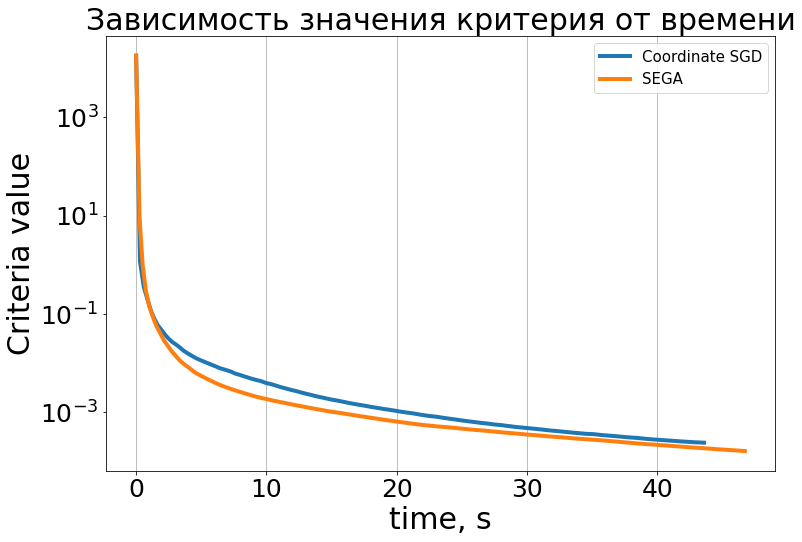

In [24]:
X1 = np.array([time1[100*i] for i in range (99)])
Y1 = np.array([gradient(X_train, y_train, res1[100*i])@gradient(X_train, y_train, res1[100*i]) for i in range (99)])

X2 = np.array([time2[100*i] for i in range (99)])
Y2 = np.array([gradient(X_train, y_train, res2[100*i])@gradient(X_train, y_train, res2[100*i]) for i in range (99)])

    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Coordinate SGD')
plt.semilogy(X2, Y2, linewidth=4, label = 'SEGA')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

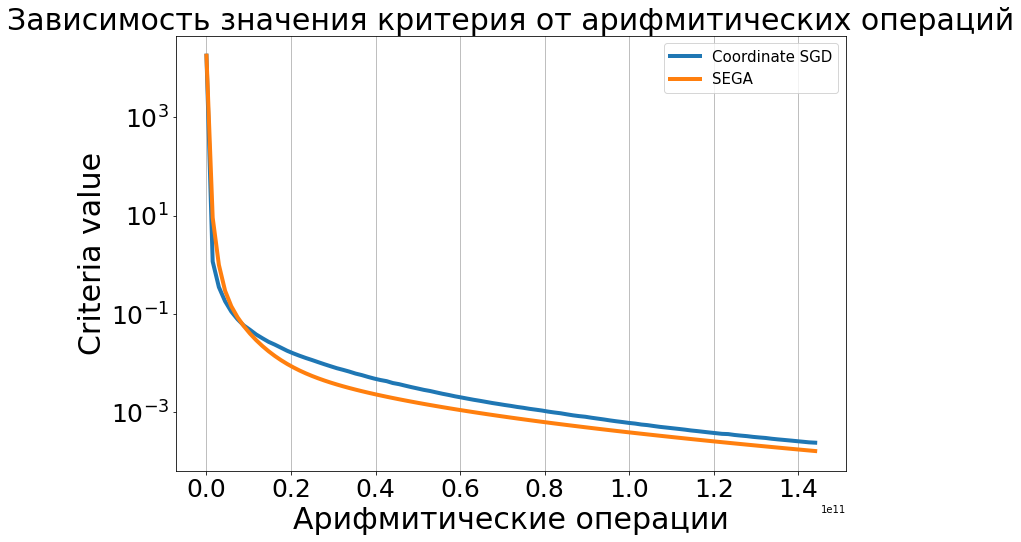

In [25]:
X1 = np.array([call1[100*i] for i in range (99)])
Y1 = np.array([gradient(X_train, y_train, res1[100*i])@gradient(X_train, y_train, res1[100*i]) for i in range (99)])

X2 = np.array([call2[100*i] for i in range (99)])
Y2 = np.array([gradient(X_train, y_train, res2[100*i])@gradient(X_train, y_train, res2[100*i]) for i in range (99)])

    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Coordinate SGD')
plt.semilogy(X2, Y2, linewidth=4, label = 'SEGA')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Арифмитические операции", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от арифмитических операций", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

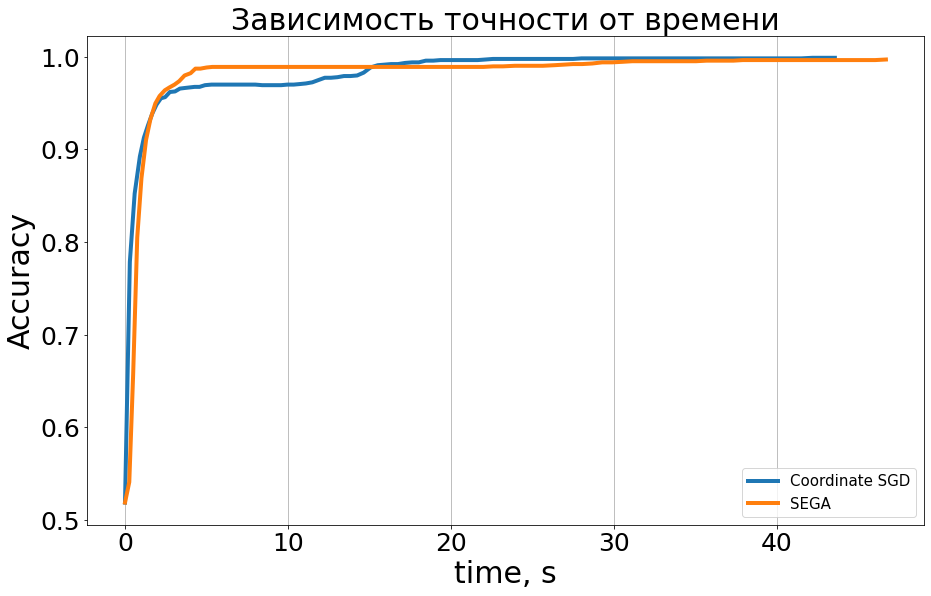

In [26]:
X1 = np.array([time1[100*i] for i in range (0, 99)])
Y1 = np.array([precisions(100*i, res1)[0] for i in range (0, 99)])

X2 = np.array([time2[100*i] for i in range (0, 99)])
Y2 = np.array([precisions(100*i, res2)[0] for i in range (0, 99)])

    
plt.figure(figsize=(15,9))

plt.plot(X1, Y1, linewidth=4, label = 'Coordinate SGD')
plt.plot(X2, Y2, linewidth=4, label = 'SEGA')

plt.legend(loc="best", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Accuracy", fontsize=30)
plt.title(r"Зависимость точности от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

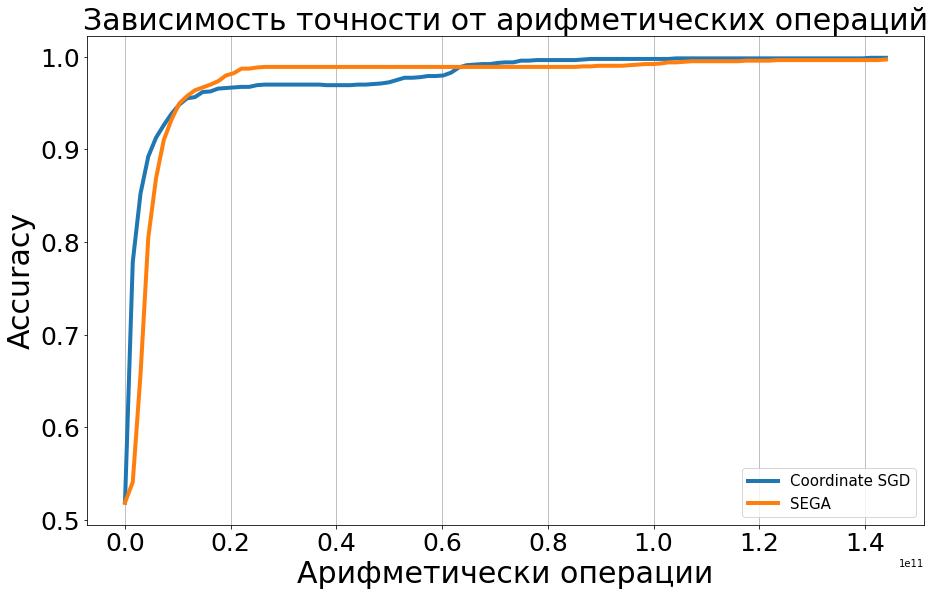

In [27]:
X1 = np.array([call1[100*i] for i in range (0, 99)])
Y1 = np.array([precisions(100*i, res1)[0] for i in range (0, 99)])

X2 = np.array([call2[100*i] for i in range (0, 99)])
Y2 = np.array([precisions(100*i, res2)[0] for i in range (0, 99)])

    
plt.figure(figsize=(15,9))

plt.plot(X1, Y1, linewidth=4, label = 'Coordinate SGD')
plt.plot(X2, Y2, linewidth=4, label = 'SEGA')

plt.legend(loc="best", fontsize=15)
plt.xlabel(r"Арифметически операции", fontsize=30)
plt.ylabel("Accuracy", fontsize=30)
plt.title(r"Зависимость точности от арифметических операций", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

### Вывод:
SEGA и CSGD при $b = 20$ с зависимым выбором сходятся примерно одинаково, но SEGA делать это немного быстрее по времени и количеству арифметических операций. Так же SEGA быстрее выходит на высокую точность, но CSGD немного точнее.

__Бонусные пункты__

__(г)__ Попробуйте объеденить подходы SAGA/SVRG/L-SVRG и координатный SGD/SEGA (т.е. могут получиться пары SAGA + координатный, SVRG + SEGA и еще четыре других). Вам достаточно выбрать одну пару. Как при этом будет выглядеть итерация метода (запишите в явном виде)? Докажите сходимость данного подхода для $\mu$-сильно выпуклой $f$ и $L$-гладкой $f_i$.

In [28]:
#ответ

__(д)__ Реализуйте новый метод. Сравните его с двумя методами, которые были взяты за базу, на задаче линейной регресии. Способы сравнения методов придумайте самостоятельно. Сделайте вывод.

In [29]:
#ответ